In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# ✅ 解法 1：在讀取 CSV 時加上 `low_memory=False`
data = pd.read_csv(
    'C:/Users/cysjo/Desktop/python for finance/小組作業1209/pyfin_assig_data.csv',
    low_memory=False  # 解決 DtypeWarning 問題
)

# ✅ 嘗試轉換有問題的類型（第 12 列的名稱可能需要檢查）
data.iloc[:, 12] = pd.to_numeric(data.iloc[:, 12], errors='coerce')

# 日期格式處理
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values(['permno', 'date'])

# 數據清理
data = data.dropna(subset=['price', 'cap', 'rsi'])
data = data[(data['price'] > 0) & (data['cap'] > 0)]

# 篩選市值 > 1000，日期範圍 2000-2015
filtered_data = data[
    (data['cap'] > 1000) &
    (data['date'] >= '2000-01-01') &
    (data['date'] <= '2015-01-01')
]

# 定義 RSI 策略回測函數
def backtest_rsi(group):
    group = group.sort_values('date')
    group['Signal'] = 0
    group.loc[group['rsi'] < 30, 'Signal'] = 1  # 買入信號
    group.loc[group['rsi'] > 70, 'Signal'] = -1  # 賣出信號
    group['Position'] = group['Signal'].shift(1).fillna(0)  # 當前信號影響下一天
    group['Daily_Return'] = group['price'].pct_change().fillna(0)
    group['Strategy_Return'] = group['Position'] * group['Daily_Return']
    group['Cumulative_Strategy_Return'] = (1 + group['Strategy_Return']).cumprod()
    return group

# ✅ 解法 2：使用 group_keys=False 來抑制警告
#result = filtered_data.groupby('permno', group_keys=False).apply(backtest_rsi)
result = filtered_data.groupby('permno', group_keys=False).apply(backtest_rsi, include_groups=False)

# 取得 RSI 策略的平均日回報
average_strategy_return = result.groupby('date')['Cumulative_Strategy_Return'].mean()

# ✅ 修復 yfinance 的 'Adj Close' 錯誤
sp500 = yf.download('^GSPC', start='2000-01-01', end='2015-01-01')

# 若 'Adj Close' 缺失，改用 'Close'
if 'Adj Close' not in sp500.columns:
    sp500['Adj Close'] = sp500['Close']

# 計算 S&P 500 的每日回報
sp500['Daily_Return'] = sp500['Adj Close'].pct_change().fillna(0)
sp500['Cumulative_Return'] = (1 + sp500['Daily_Return']).cumprod()


[*********************100%***********************]  1 of 1 completed


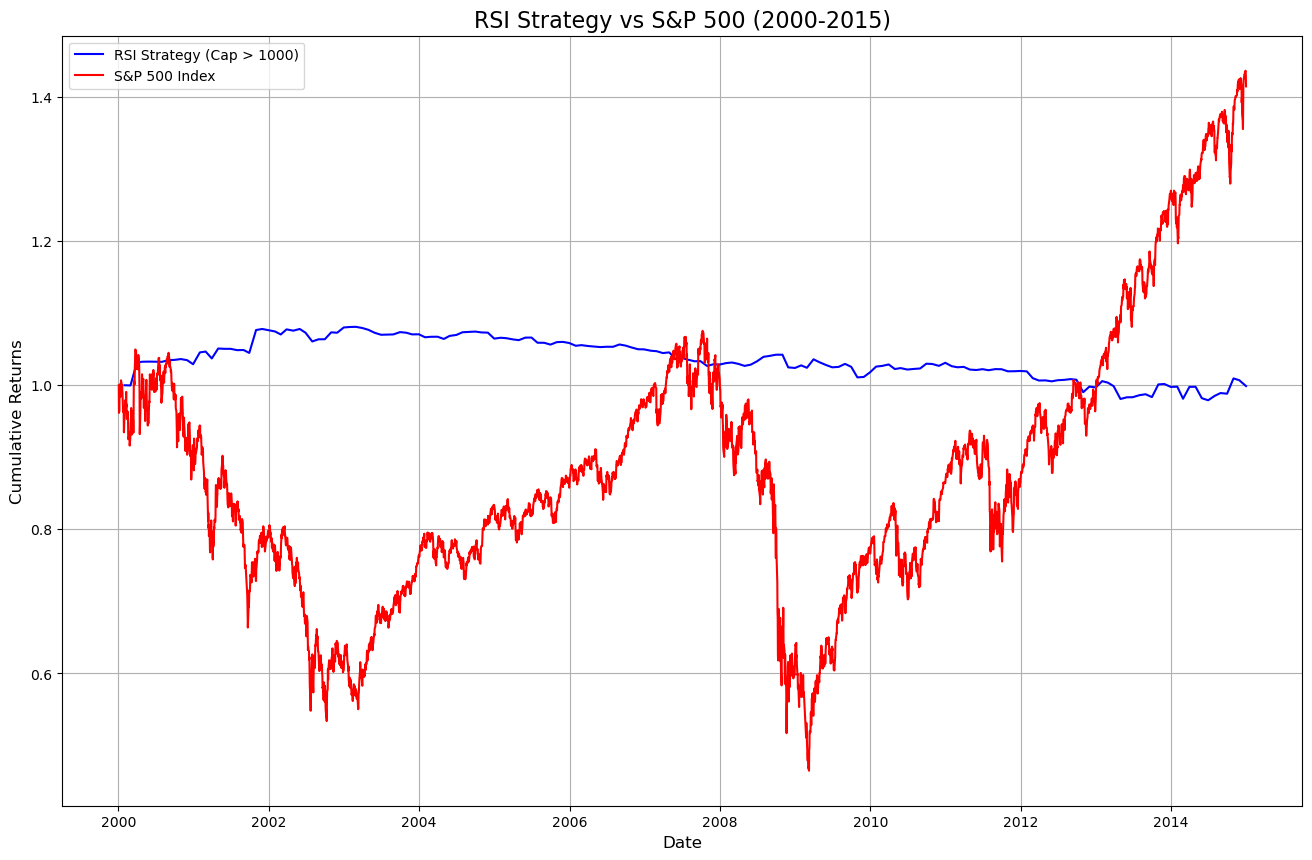

In [62]:
#  RSI 策略 vs S&P 500 回報比較圖
plt.figure(figsize=(16, 10))
plt.plot(average_strategy_return.index, average_strategy_return, label='RSI Strategy (Cap > 1000)', color='blue')
plt.plot(sp500.index, sp500['Cumulative_Return'], label='S&P 500 Index', linestyle='-', color='red')
plt.title('RSI Strategy vs S&P 500 (2000-2015)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

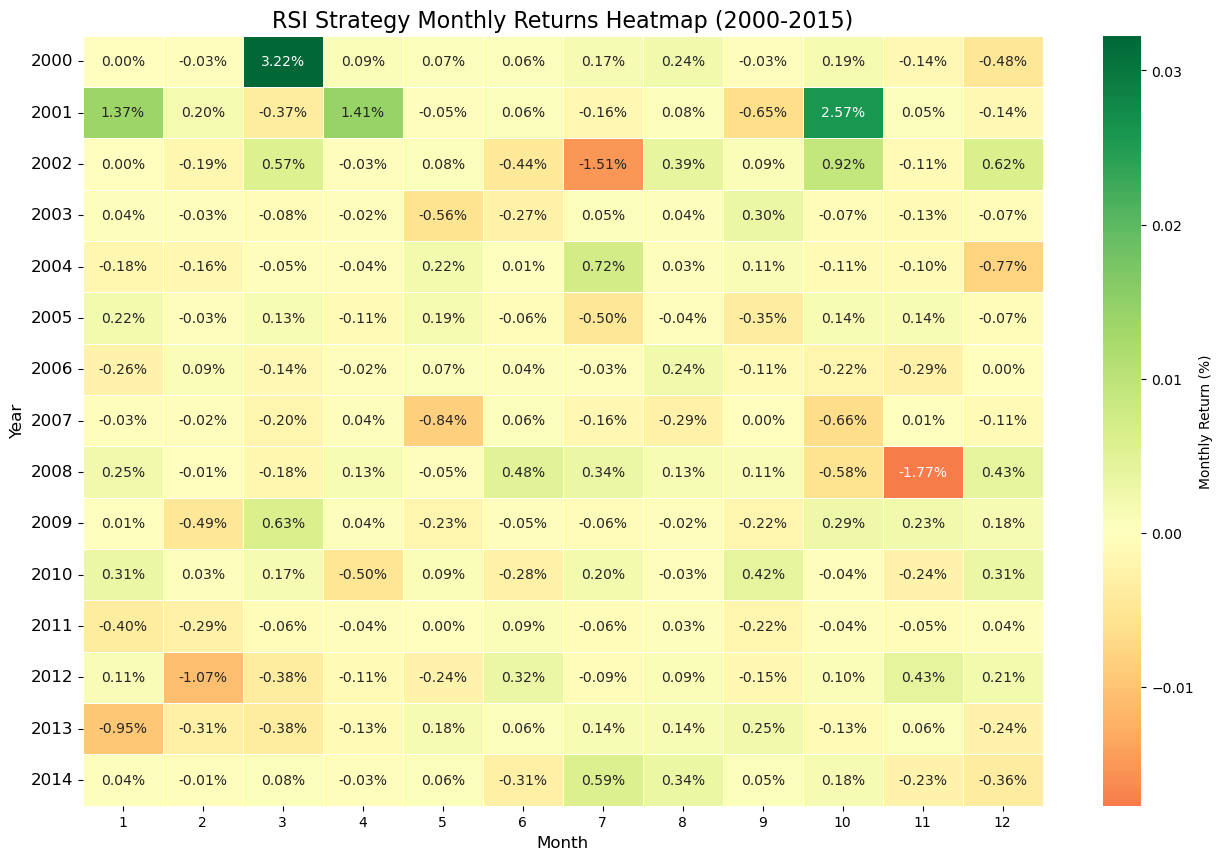

In [63]:
monthly_returns = result.groupby('date')['Strategy_Return'].mean().dropna().reset_index()
monthly_returns['year'] = monthly_returns['date'].dt.year
monthly_returns['month'] = monthly_returns['date'].dt.month

heatmap_data = monthly_returns.pivot(index='year', columns='month', values='Strategy_Return')

plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap='RdYlGn',
    annot=True,
    fmt=".2%",
    linewidths=0.5,
    center=0,
    cbar_kws={'label': 'Monthly Return (%)'}
)

plt.yticks(fontsize=12, rotation=0)
plt.subplots_adjust(left=0.15)
plt.title('RSI Strategy Monthly Returns Heatmap (2000-2015)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Year', fontsize=12)

plt.show()


In [69]:
# ✅ 計算 RSI 策略績效指標
def calculate_metrics(returns, benchmark_returns, risk_free_rate=0.038):
    metrics = {}
    # 平均回報
    metrics['mean_return'] = returns.mean()
    # 波動率
    metrics['volatility'] = returns.std()
    # 夏普比率
    excess_return = returns - risk_free_rate / 12  # 月化
    metrics['sharpe_ratio'] = excess_return.mean() / metrics['volatility']
    # 最大回撤
    cumulative_returns = (1 + returns).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    metrics['max_drawdown'] = drawdown.min()
    # jensen's alpha
    beta = np.cov(returns, benchmark_returns)[0, 1] / np.var(benchmark_returns)
    alpha = returns.mean() - (risk_free_rate / 12 + beta * (benchmark_returns.mean() - risk_free_rate / 12))
    metrics['jensen_alpha'] = alpha
    # VaR 和預期損失
    metrics['VaR_95'] = np.percentile(returns, 5)
    metrics['expected_shortfall'] = returns[returns <= metrics['VaR_95']].mean()
    return metrics

benchmark_monthly_return = sp500['Daily_Return'].resample('ME').mean().reindex(monthly_returns['date'], fill_value=0)
metrics = calculate_metrics(monthly_returns['Strategy_Return'], benchmark_monthly_return)

# output
print("\nRSI Strategy Performance Metrics (2000-2015):")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")


RSI Strategy Performance Metrics (2000-2015):
mean_return: 0.0001
volatility: 0.0047
sharpe_ratio: -0.6536
max_drawdown: -0.0759
jensen_alpha: -0.0015
VaR_95: -0.0056
expected_shortfall: -0.0098
